In [1]:
!pip install pysurvival
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install pycox

     |████████████████████████████████| 4.8MB 12.3MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774954 sha256=f5018b417c5958ef42489744e4424c97a5be8848e39d50b03cd2229edd2e28a7
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12076 sha256=a3215a658c689334c829b1fe42ac8880ebc38e640b7c4c695d3a81b467e58e00
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 348kB 10.5MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=1904649e8527ae5535b65f86e241672220dd0c6251c618d51082516f03f28e09
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-g

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
%pylab inline
from google.colab import files
uploaded = files.upload()
torch.cuda.set_device(0)

Populating the interactive namespace from numpy and matplotlib


Saving telecom.csv to telecom.csv


In [ ]:
#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
torch.cuda.is_available()
seed = 7
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#np.random.seed(seed)

In [2]:
import io 
df = pd.read_csv(io.BytesIO(uploaded['telecom.csv']))
ids = df[['customerID']]
df.drop(columns=['customerID'], inplace=True)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
l = []
for j, i in enumerate(df['TotalCharges']):
    try:
        float(i)
    except ValueError:
        print(j, '_________', i)
        l.append(j)
df.drop(l, inplace = True ) 
df['TotalCharges'] = df['TotalCharges'].astype(float)
df = df.reset_index( drop = True )

488 _________  
753 _________  
936 _________  
1082 _________  
1340 _________  
3331 _________  
3826 _________  
4380 _________  
5218 _________  
6670 _________  
6754 _________  


In [4]:
binary = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
categorical = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
numerical = ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']
df = pd.get_dummies(df, columns=binary, drop_first=True)
df = pd.get_dummies(df, columns=categorical)
# Creating the time and event columns
time_column = 'tenure'
event_column = 'Churn_Yes'
 
# Extracting the features
features = np.setdiff1d(df.columns, [time_column, event_column] ).tolist()

In [5]:
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.3, random_state=0, stratify=df['Churn_Yes'])

tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.2, random_state=0, stratify=tmp_data_train['Churn_Yes'])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(X_train[['MonthlyCharges', 'TotalCharges']])
scaled_valid = scaler.fit_transform(X_valid[['MonthlyCharges', 'TotalCharges']])
scaled_test = scaler.transform(X_test[['MonthlyCharges', 'TotalCharges']])
X_train[['MonthlyCharges', 'TotalCharges']], X_valid[['MonthlyCharges', 'TotalCharges']], X_test[['MonthlyCharges', 'TotalCharges']] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


((3937, 39), (985, 39), (2110, 39))

In [6]:
from pysurvival.models.multi_task import LinearMultiTaskModel
from pysurvival.utils.metrics import concordance_index as pys_concordance_index, brier_score as pys_brier_score, integrated_brier_score as pys_integrated_brier_score
lmtlr = LinearMultiTaskModel(bins=73)
lmtlr.fit(X_train, T_train, E_train, lr=1e-3, init_method='glorot_uniform', num_epochs=5000, is_min_time_zero=False, extra_pct_time=0.1)
train_c_index = pys_concordance_index(lmtlr, X_train, T_train, E_train)
test_c_index = pys_concordance_index(lmtlr, X_test, T_test, E_test)
 
#train_brier = pys_brier_score(lmtlr, X_train, T_train, E_train)
#test_brier = pys_brier_score(lmtlr, X_test, T_test, E_test)
train_ibs = pys_integrated_brier_score(lmtlr, X_train, T_train, E_train)
test_ibs = pys_integrated_brier_score(lmtlr, X_test, T_test, E_test)
 
train_c_index, test_c_index, train_ibs, test_ibs

(0.7248451176995934,
 0.7211596454764917,
 0.013113921571190902,
 0.01978458000022089)

In [15]:
_, density, _ = lmtlr.predict(X_test)
density.shape

(2110, 73)

In [18]:
np.sum(lmtlr.predict_density(X_test), 0)

array([137.08400951,  42.32604809,  43.26968826,  44.48546536,
        37.54334853,  22.88456148,  58.65161933,  30.88983019,
        26.33068696,  18.93537865,  31.2423731 ,  21.27268117,
        17.88238195,  44.49782209,  14.76093601,  14.52470522,
        15.58466734,  25.59105254,  17.17661573,  36.43080711,
        10.61628253,  19.12327846,  27.84382856,   9.71480281,
        13.21223606,   9.68313167,   9.23907   ,  18.84791704,
        17.2728752 ,  32.99119332,  20.29140072,  13.33145356,
        14.10056529,  20.95411001,  18.22571434,  30.42642622,
        11.86464848,  12.46450346,   9.91589678,  14.14856271,
         8.07817704,  22.64771516,  15.86431039,  19.60957353,
        17.51862866,  10.7752992 ,   6.77465728,   9.76354503,
        28.51897128,  12.57336368,  11.37237794,  12.97857254,
        24.23914176,   9.49867392,   5.62211897,   6.37732547,
         4.48367111,   5.57456766,   4.81281486,  12.01222021,
        13.21940437,  16.4449363 ,   8.96311567,  10.91

In [ ]:
ci_scikit(E_test.astype(np.bool), T_test, lmtlr.predict_risk(X_test))[0], concordance_index(T_test, -lmtlr.predict_risk(X_test), E_test.astype(np.bool))

(0.8271766820113978, 0.8271766820113978)

In [ ]:
from pycox.evaluation import EvalSurv
ev = EvalSurv(pd.DataFrame(lmtlr.predict_survival(X_test.values).T), T_test.values, E_test.values, censor_surv='km')
ev.concordance_td(), ev.integrated_brier_score(lmtlr.times) 

ModuleNotFoundError: ignored

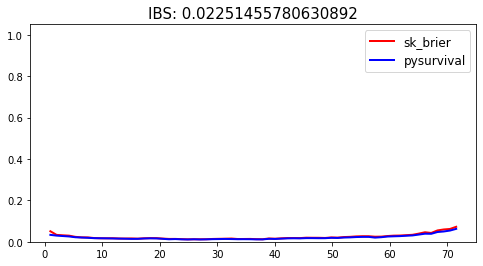

In [ ]:
sk_brier = []
times, pys_brier = pys_brier_score(lmtlr, X_test, T_test, E_test)
 
for j, i in enumerate(times):
    _, score = brier_score(np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4'), 
                           np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4'), lmtlr.predict_survival(X_test)[:,j], i)     #    lmtlr.predict_survival(X_test.iloc[[0]])
    sk_brier.append(score[0])
 
fig, ax = plt.subplots(figsize=(8, 4))
 
plt.plot(lmtlr.times[:np.argmax(lmtlr.times>max(T_train))], sk_brier, color='red', label='sk_brier', lw=2)
plt.plot(times, pys_brier, color='blue', label='pysurvival', lw=2)
 
#ci_scikit(E_test.astype(np.bool), T_test, lmtlr.predict_risk(X_test))[0], concordance_index(T_test, -lmtlr.predict_risk(X_test), E_test.astype(np.bool))
ibs = np.trapz(sk_brier, times)/max(T_train)
 
# Show everything
title = "IBS: "+str(ibs)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.

In [ ]:
from pysurvival.models.multi_task import NeuralMultiTaskModel
n_mtlr = NeuralMultiTaskModel(structure=[{'activation': 'LeakyReLU', 'num_units': 150}, {'activation': 'LeakyReLU', 'num_units': 250}, {'activation': 'LeakyReLU', 'num_units': 300}], bins=73)
n_mtlr.fit(X_train, T_train, E_train, lr=1e-4, init_method='glorot_uniform', num_epochs=1000)

train_c_index = pys_concordance_index(n_mtlr, X_train, T_train, E_train)
test_c_index = pys_concordance_index(n_mtlr, X_test, T_test, E_test)
 
train_ibs = pys_integrated_brier_score(n_mtlr, X_train, T_train, E_train)
test_ibs = pys_integrated_brier_score(n_mtlr, X_test, T_test, E_test)

train_c_index, test_c_index, train_ibs, test_ibs

(0.8973604543847077,
 0.862671051559757,
 0.01718606263781717,
 0.03164171857308528)

In [ ]:
sk_brier = []
times, pys_brier = pys_brier_score(lmtlr, X_test, T_test, E_test)
 
for j, i in enumerate(times):
    _, score = brier_score(np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4'), 
                           np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4'), n_mtlr.predict_survival(X_test)[:,j], i)     #    lmtlr.predict_survival(X_test.iloc[[0]])
    sk_brier.append(score[0])
 
fig, ax = plt.subplots(figsize=(8, 4))
 
plt.plot(n_mtlr.times[:np.argmax(n_mtlr.times>max(T_train))], sk_brier, color='red', label='sk_brier', lw=2)
plt.plot(times, pys_brier, color='blue', label='pysurvival', lw=2)
 
#ci_scikit(E_test.astype(np.bool), T_test, lmtlr.predict_risk(X_test))[0], concordance_index(T_test, -lmtlr.predict_risk(X_test), E_test.astype(np.bool))
ibs = np.trapz(sk_brier, times)/max(T_train)
 
# Show everything
title = "IBS: "+str(ibs)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.

In [ ]:
'''class LR(nn.Module):
    def __init__(self, input_size, num_time_bins):
        super().__init__()
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.fc = torch.nn.Linear(self.input_size, self.num_time_bins-1)
        self.register_buffer("G",
                             torch.tril(torch.ones(self.num_time_bins-1, self.num_time_bins, requires_grad=True)))
        self.reset_parameters()
 
    def forward(self, x):
        out = self.fc(x)
        return torch.matmul(out, self.G)
 
    def reset_parameters(self):
        """Resets the model parameters."""
        #nn.init.xavier_normal_(self.fc.weight)
        nn.init.xavier_uniform_(self.fc.weight)
 
class SURV_DATA(Dataset):
    def __init__(self, x, t, e, num_time_bins):
        self.x, self.t, self.e = x.astype(np.float32), t.astype(np.float32), e.astype(np.float32)  # x:2D numpy arr, (t.e):1D numpy arr
        self.num_time_bins = num_time_bins
        self.masks = self.__process_labels()
 
    def __process_labels(self):
        mask = np.zeros([self.x.shape[0], self.num_time_bins])  # for the first loss function
        for i in range(self.x.shape[0]):
            if self.e[i] != 0:  # not censored
                mask[i, int(self.t[i])] = 1
            else:  # label[i,2]==0: censored
                mask[i, int(self.t[i] + 1):] = 1  # fill 1 until from the censoring time (to get 1 - \sum F)
        return mask
 
    def __len__(self):
        return len(self.e)
 
    def __getitem__(self, idx):
        return self.x[idx], self.masks[idx]
 
 
class MTLR():
    def __init__(self, model, input_size, num_time_bins, train_load, test_load):
        self.train_load = train_load
        self.test_load = test_load
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model(input_size, num_time_bins).to(self.device)
 
    def masked_logsumexp(self, x, mask, dim=-1):
        max_val, _ = (x * mask).max(dim=dim)
        max_val = torch.clamp_min(max_val, 0)
        return torch.log(torch.sum(torch.exp(x - max_val.unsqueeze(dim)) * mask, dim=dim)) + max_val
 
    def norm_diff(self, W):
        """ Special norm function for the last layer of the MTLR """
        dims=len(W.shape)
        if dims==1:
            diff = W[1:]-W[:-1]
        elif dims==2:
            diff = W[1:, :]-W[:-1, :]
        return torch.sum(diff*diff)
 
    def mtlr_neg_log_likelihood(self, logits, target, l2_reg, l2_smooth, average=False):
        censored = target.sum(dim=1) > 1
        if censored.any():
            nll_censored = self.masked_logsumexp(logits[censored], target[censored]).sum()
        else:
            nll_censored = 0.
        if (~censored).any():
            nll_uncensored = (logits[~censored] * target[~censored]).sum()
        else:
            nll_uncensored = 0.
 
        # the normalising constant
        norm = torch.logsumexp(logits, dim=1).sum()
        nll_total = -(nll_censored + nll_uncensored - norm)
        if average:
            nll_total = nll_total / target.size(0)
 
        nb_set_parameters = len(list(self.model.parameters()))
        for i, w in enumerate(self.model.parameters()):
            nll_total += l2_reg*torch.sum(w*w)/2.
            
            if i >= nb_set_parameters - 2:
                nll_total += l2_smooth*self.norm_diff(w)
        return nll_total
 
    def train_model(self, lr, l2_reg, l2_smooth):
        self.model.train()
        sum_loss = 0
        optim = Adam(self.model.parameters(), lr=lr)
        for i, xy in enumerate(self.train_load):
            x, y = xy
            x, y = x.to(self.device), y.to(self.device)
            batch = y.shape[0]
            output = self.model(x)
            loss = self.mtlr_neg_log_likelihood(output, y, l2_reg, l2_smooth)
            optim.zero_grad()
            loss.backward()
            optim.step()
            sum_loss += loss.item()
        return sum_loss / (i + 1)
 
    def eval_model(self, l2_reg, l2_smooth):
        self.model.eval()
        sum_loss = 0
        correct = 0
        for i, xy in enumerate(self.test_load):
            x, y = xy
            x, y = x.to(self.device), y.to(self.device)
            output = self.model(x)
            loss = self.mtlr_neg_log_likelihood(output, y, l2_reg, l2_smooth)
            sum_loss += loss.item()
        return sum_loss / (i + 1)
 
    def fit(self, epoch, lr, l2_reg=1e-2, l2_smooth=1e-2, eval=True):
        for i in range(epoch):
            print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(lr, l2_reg, l2_smooth)
            print('train loss : ' ,train_loss)
            if (eval) or (i==epoch-1):
                test_loss = self.eval_model(l2_reg, l2_smooth)
                print('test loss : ' ,test_loss)
            #print('\n')
 
    def predict_survival(self, x):
        x = torch.tensor(x.astype(np.float32)).to(self.device)
        with torch.no_grad():
            output = self.model(x)
        G = torch.tril(torch.ones(output.size(1), output.size(1))).to(self.device)
        density = torch.softmax(output, dim=1)
        return torch.matmul(density, G)'''
 
'''class LR(nn.Module):
    def __init__(self, input_size, num_time_bins):
        super().__init__()
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.fc = torch.nn.Linear(self.input_size, self.num_time_bins)
        self.reset_parameters()
 
    def forward(self, x):
        out = self.fc(x)
        return out
 
    def reset_parameters(self):
        self.fc.weight = nn.init.xavier_normal_(self.fc.weight)
        self.fc.bias = nn.init.constant_(self.fc.bias, 0.001)
 
    def reset_parameters(self):
        """Resets the model parameters."""
        #nn.init.xavier_normal_(self.fc.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.xavier_uniform_(self.fc.bias)
 
    
 
 
class CENSORED_SURV_DATA(Dataset):
    def __init__(self, X_cens, Y_cens):
        self.X_cens, self.Y_cens = X_cens.astype(np.float32), Y_cens.astype(np.float32)
 
    def __len__(self):
        return len(self.X_cens)
 
    def __getitem__(self, idx):
        return self.X_cens[idx], self.Y_cens[idx]
 
class UNCENSORED_SURV_DATA(Dataset):
    def __init__(self, X_uncens, Y_uncens):
        self.X_uncens, self.Y_uncens = X_uncens.astype(np.float32), Y_uncens.astype(np.float32)
 
    def __len__(self):
        return len(self.X_uncens)
 
    def __getitem__(self, idx):
        return self.X_uncens[idx], self.Y_uncens[idx]
 
class MTLR():
    def __init__(self, model, input_size, num_time_bins):
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model(self.input_size, self.num_time_bins).to(self.device)
        self.triangle = torch.FloatTensor(np.tri(self.num_time_bins, self.num_time_bins + 1, dtype=np.float32))
 
    def process_data(self, x, t, e):
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        for i in range(x.shape[0]):
            if e[i] != 0:  # not censored
                tmp = np.zeros((self.num_time_bins + 1))
                tmp[int(t[i])] = 1
                X_uncens.append(x[i,:]), Y_uncens.append(tmp)
            else:  # label[i,2]==0: censored
                tmp = np.zeros((self.num_time_bins + 1))
                tmp[int(t[i] + 1):] = 1  # fill 1 until from the censoring time (to get 1 - \sum F)
                X_cens.append(x[i,:]), Y_cens.append(tmp)
        return np.asarray(X_uncens), np.asarray(Y_uncens), np.asarray(X_cens), np.asarray(Y_cens)
 
    def norm_diff(self, W):
        """ Special norm function for the last layer of the MTLR """
        dims=len(W.shape)
        if dims==1:
            diff = W[1:]-W[:-1]
        elif dims==2:
            diff = W[1:, :]-W[:-1, :]
        return torch.sum(diff*diff)
 
    def loss_function(self, X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth):
        
        # Likelihood Calculations -- Uncensored
        score_uncens = self.model(X_uncens)
        phi_uncens = torch.exp( torch.mm(score_uncens, self.triangle) )
        reduc_phi_uncens = torch.sum(phi_uncens*Y_uncens, dim = 1)
 
        # Likelihood Calculations -- Censored
        score_cens = self.model(X_cens)
        phi_cens = torch.exp( torch.mm(score_cens, self.triangle) )
        reduc_phi_cens = torch.sum( phi_cens*Y_cens, dim = 1)
 
        # Likelihood Calculations -- Normalization
        z_uncens = torch.exp( torch.mm(score_uncens, self.triangle) )
        reduc_z_uncens = torch.sum( z_uncens, dim = 1)
 
        z_cens = torch.exp( torch.mm(score_cens, self.triangle) )
        reduc_z_cens = torch.sum( z_cens, dim = 1)
 
        # MTLR cost function
        loss = - (
                    torch.sum( torch.log(reduc_phi_uncens) ) \
                  + torch.sum( torch.log(reduc_phi_cens) )  \
 
                  - torch.sum( torch.log(reduc_z_uncens) ) \
                  - torch.sum( torch.log(reduc_z_cens) ) 
                 )
 
        # Adding the regularized loss
        nb_set_parameters = len(list(self.model.parameters()))
        for i, w in enumerate(self.model.parameters()):
            loss += l2_reg*torch.sum(w*w)/2.
            
            if i >= nb_set_parameters - 2:
                loss += l2_smooth*self.norm_diff(w)
                
        return loss
 
    def train_model(self, uncens_train_load, cens_train_load, lr, l2_reg, l2_smooth):
        self.model.train()
        sum_loss = 0
        optim = Adam(self.model.parameters(), lr=lr)
        for i, (uncens, cens) in enumerate(zip(uncens_train_load, cens_train_load)):
            X_uncens, Y_uncens = uncens
            X_cens, Y_cens = cens
            X_uncens, Y_uncens, X_cens, Y_cens = X_uncens.to(self.device), Y_uncens.to(self.device), X_cens.to(self.device), Y_cens.to(self.device)
            loss = self.loss_function(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
            optim.zero_grad()
            loss.backward()
            optim.step()
            sum_loss += loss.item()
        return sum_loss / (i + 1)
 
    def eval_model(self, uncens_test_load, cens_test_load, l2_reg, l2_smooth):
        self.model.eval()
        sum_loss = 0
        for i, (uncens, cens) in enumerate(zip(uncens_test_load, cens_test_load)):
            X_uncens, Y_uncens = uncens
            X_cens, Y_cens = cens
            X_uncens, Y_uncens, X_cens, Y_cens = X_uncens.to(self.device), Y_uncens.to(self.device), X_cens.to(self.device), Y_cens.to(self.device)
            loss = self.loss_function(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
            sum_loss += loss.item()
        return sum_loss / (i + 1)
 
    def fit(self, X_train, T_train, E_train, epoch, lr, batch_size, X_test=None, T_test=None, E_test=None, l2_reg=1e-2, l2_smooth=1e-2):
 
        X_train_uncens, Y_train_uncens, X_train_cens, Y_train_cens = self.process_data(X_train, T_train, E_train)
        X_test_uncens, Y_test_uncens, X_test_cens, Y_test_cens = self.process_data(X_test, T_test, E_test)
 
        uncens_train_load = DataLoader(UNCENSORED_SURV_DATA(X_train_uncens, Y_train_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, Y_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_train_load = DataLoader(CENSORED_SURV_DATA(X_train_cens, Y_train_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, Y_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        for i in range(epoch):
            print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(uncens_train_load, cens_train_load, lr, l2_reg, l2_smooth)
            print('train loss : ' ,train_loss)
            if X_test is not None:
                test_loss = self.eval_model(uncens_test_load, cens_test_load, l2_reg, l2_smooth)
                print('test loss : ' ,test_loss)
            #print('\n')
 
    def predict_survival(self, x):
        x = torch.tensor(x.astype(np.float32)).to(self.device)
        with torch.no_grad():
            output = self.model(x).data.numpy()
        
        Triangle1 = np.tri(self.num_time_bins , self.num_time_bins + 1 )
        Triangle2 = np.tri(self.num_time_bins + 1, self.num_time_bins + 1)
        phi = np.exp( np.dot(output, Triangle1) )
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = (phi/div)
        return np.dot(density, Triangle2)'''
 
class LRMultiTask(nn.Module):
    def __init__(self, input_size, num_time_bins):
        super().__init__()
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.fc = torch.nn.Linear(self.input_size, self.num_time_bins - 1)
        self.reset_parameters()
 
    def forward(self, x):
        out = self.fc(x)
        return out
 
    def reset_parameters(self):
        self.fc.weight = nn.init.xavier_normal_(self.fc.weight)
        self.fc.bias = nn.init.constant_(self.fc.bias, 0.001)
 
 
 
class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, dropout=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.network = nn.ModuleList()
        if self.factors:
            self.units = self.input_shape * np.asarray(self.factors)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if dropout is None else dropout
            for i, j in zip(self.units, self.dropout):
              block = self.__build_block__(input_shape, i, p=j)
              self.network.extend(block)
              input_shape = i
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, norm=False):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not norm))
        if norm:
            block.append(nn.BatchNorm1d(units))
        block.append(nn.LeakyReLU())
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
 
class NN_Multi_Task(nn.Module):
    def __init__(self, input_shape, num_time_bins, units=None, factors=None, dropout=None):
        super(NN_Multi_Task, self).__init__()
        self.nn_model = NNModel(input_shape, units, factors, dropout)
        self.mtlr = LRMultiTask(self.nn_model.units[-1], num_time_bins)
 
    def forward(self, x):
        x = self.nn_model(x)
        x = self.mtlr(x)
        return x
 
class CENSORED_SURV_DATA(Dataset):
    def __init__(self, X_cens, Y_cens):
        self.X_cens, self.Y_cens = X_cens.astype(np.float32), Y_cens.astype(np.float32)
 
    def __len__(self):
        return len(self.X_cens)
 
    def __getitem__(self, idx):
        return self.X_cens[idx], self.Y_cens[idx]
 
class UNCENSORED_SURV_DATA(Dataset):
    def __init__(self, X_uncens, Y_uncens):
        self.X_uncens, self.Y_uncens = X_uncens.astype(np.float32), Y_uncens.astype(np.float32)
 
    def __len__(self):
        return len(self.X_uncens)
 
    def __getitem__(self, idx):
        return self.X_uncens[idx], self.Y_uncens[idx]
 
class MTLR():
    def __init__(self, model, input_size, num_time_bins):
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model#.to(self.device) #builded model
        self.triangle = torch.FloatTensor(np.tri(self.num_time_bins - 1, self.num_time_bins, dtype=np.float32))
        self.times = None
        self.losses = {'Epoch': [], 'Train': [], 'Test': []}
 
    def _process_data(self, x, t, e):
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        for i in range(x.shape[0]):
            if e[i] != 0:  # not censored
                tmp = np.zeros((self.num_time_bins))
                tmp[int(t[i]) - 1] = 1
                X_uncens.append(x[i,:]), Y_uncens.append(tmp)
            else:  # label[i,2]==0: censored
                tmp = np.zeros((self.num_time_bins))
                tmp[int(t[i]) - 1:] = 1  # fill 1 until from the censoring time (to get 1 - \sum F)
                X_cens.append(x[i,:]), Y_cens.append(tmp)
        return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens))
 
    def process_data(self, data, time, event):
        bin_idxs = np.digitize(time, self.times)
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        for i, e in enumerate(event):
            bin_idx = bin_idxs[i]
            tmp = np.zeros((self.num_time_bins))
            if e == 1: #not censored              
                tmp[bin_idx] = 1
                X_uncens.append(data[i,:]), Y_uncens.append(tmp)
            else:
                tmp[bin_idx:] = 1
                X_cens.append(data[i,:]), Y_cens.append(tmp)
        return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens))
 
    def norm_diff(self, W):
            """ Special norm function for the last layer of the MTLR """
            dims=len(W.shape)
            if dims==1:
                diff = W[1:]-W[:-1]
            elif dims==2:
                diff = W[1:, :]-W[:-1, :]
            return torch.sum(diff*diff)
 
    def loss_function(self, X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth):
        
        # Likelihood Calculations -- Uncensored
        score_uncens = self.model(X_uncens)
        phi_uncens = torch.exp( torch.mm(score_uncens, self.triangle) )
        reduc_phi_uncens = torch.sum(phi_uncens*Y_uncens, dim = 1)
 
        # Likelihood Calculations -- Censored
        score_cens = self.model(X_cens)
        phi_cens = torch.exp( torch.mm(score_cens, self.triangle) )
        reduc_phi_cens = torch.sum( phi_cens*Y_cens, dim = 1)
 
        # Likelihood Calculations -- Normalization
        z_uncens = torch.exp( torch.mm(score_uncens, self.triangle) )
        reduc_z_uncens = torch.sum( z_uncens, dim = 1)
 
        z_cens = torch.exp( torch.mm(score_cens, self.triangle) )
        reduc_z_cens = torch.sum( z_cens, dim = 1)
 
        # MTLR cost function
        loss = - (
                    torch.sum( torch.log(reduc_phi_uncens) ) \
                  + torch.sum( torch.log(reduc_phi_cens) )  \
 
                  - torch.sum( torch.log(reduc_z_uncens) ) \
                  - torch.sum( torch.log(reduc_z_cens) ) 
                 )
 
        # Adding the regularized loss
        nb_set_parameters = len(list(self.model.parameters()))
        for i, w in enumerate(self.model.parameters()):
            loss += l2_reg*torch.sum(w*w)/2.
            
            if i >= nb_set_parameters - 2:
                loss += l2_smooth*self.norm_diff(w)
                
        return loss
 
    def train_model(self, optim, X_cens, X_uncens, Y_cens, Y_uncens, lr, l2_reg, l2_smooth):
        optim.zero_grad()
        self.model = self.model.train()
        loss = self.loss_function(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
        loss.backward()
        optim.step()
        return loss.item()
 
    def eval_model(self, X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth):
        self.model = self.model.eval()
        loss = self.loss_function(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
        return loss.item()
 
    def fit(self, X_train, T_train, E_train, epoch, lr, batch_size, X_test=None, T_test=None, E_test=None, l2_reg=1e-2, l2_smooth=1e-2, is_min_time_zero = False, extra_pct_time = 0., eval=True):
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
        X_train_uncens, Y_train_uncens, X_train_cens, Y_train_cens = self.process_data(X_train, T_train, E_train)
        X_test_uncens, Y_test_uncens, X_test_cens, Y_test_cens = self.process_data(X_test, T_test, E_test)
 
        '''X_train_cens, X_train_uncens, Y_train_cens, Y_train_uncens = lmtlr.compute_XY(X_train, T_train, E_train, is_min_time_zero, extra_pct_time)
        if X_test is not None:
            X_test_cens, X_test_uncens, Y_test_cens, Y_test_uncens = lmtlr.compute_XY(X_test, T_test, E_test, is_min_time_zero, extra_pct_time)'''
 
        '''"""print(np.array_equal(tmp_X_cens.data.numpy(),X_cens))
        print(np.array_equal(tmp_X_uncens.data.numpy(),X_uncens))
        print(np.array_equal(tmp_Y_cens.data.numpy(),Y_cens))
        print(np.array_equal(tmp_Y_uncens.data.numpy(),Y_uncens))"""
 
        """print(np.where(tmp_Y_cens.data.numpy() - Y_cens.data.numpy()))
        print(np.where(tmp_Y_uncens.data.numpy() - Y_uncens.data.numpy()))"""
 
        X_test_uncens, Y_test_uncens, X_test_cens, Y_test_cens = self.process_data(X_test, T_test, E_test)
        X_cens, X_uncens, Y_cens, Y_uncens = X_test_cens.to(self.device), X_test_uncens.to(self.device), Y_test_cens.to(self.device), Y_test_uncens.to(self.device)'''
 
        #optim = opt.Adam(self.model.parameters(), lr=lr)
        optim = opt.SGD(self.model.parameters(), lr=lr, momentum=0.9, nesterov=True)
        scheduler = opt.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=15, verbose=True)

        eval_score = ''
        for i in range(epoch):
            #print(optim.param_groups[0]['lr'])
            print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(optim, X_train_cens, X_train_uncens, Y_train_cens, Y_train_uncens, lr, l2_reg, l2_smooth)
            print('train loss : ' ,train_loss)
            if np.isnan(train_loss) or np.isinf(train_loss):
                print('Stop training')
                break
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
            if X_test is not None:
                test_loss = self.eval_model(X_test_cens, X_test_uncens, Y_test_cens, Y_test_uncens, l2_reg, l2_smooth)
                #metric = self.c_index(X_test, T_test, E_test)
                if eval:
                    _, eval_score = self.b_index(X_train, T_train, E_train, X_test, T_test, E_test, plot=False)
                print('test loss : ' ,test_loss, ' _______ Metric : ', eval_score)
                self.losses['Test'].append(test_loss)
                if scheduler is not None:
                    scheduler.step(test_loss)
 
    def predict(self, x):
        x = torch.tensor(x.astype(np.float32))#.to(self.device)
        with torch.no_grad():
            output = self.model(x).data.numpy()
        
        Triangle1 = np.tri(self.num_time_bins - 1, self.num_time_bins)
        Triangle2 = np.tri(self.num_time_bins, self.num_time_bins)
        phi = np.exp( np.dot(output, Triangle1) )
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = (phi/div)
        survival = np.dot(density, Triangle2)
        hazard = density[:, :-1]/survival[:, 1:]
        return hazard, density, survival
 
    def c_index(self, x, t, e):
        hazard, density, survival = self.predict(x)
        cumulative_hazard = np.cumsum(hazard, 1)
        risk = np.sum(cumulative_hazard, 1)
        res = ci_scikit(e.astype(np.bool), t, risk)[0]
        return res
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, plot=True):
        time_idx = self.times[:np.argmax(self.times>max(T_train))] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        _, _, survival = self.predict(X_test)
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt
        
# the probability that an individual within the population will survive longer than time t. 
 
 
'''class LR(nn.Module):
    def __init__(self, input_size, num_time_bins):
        super().__init__()
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.fc = torch.nn.Linear(self.input_size, self.num_time_bins)
        self.reset_parameters()
 
    def forward(self, x):
        out = self.fc(x)
        return out
 
    def reset_parameters(self):
        self.fc.weight = nn.init.xavier_normal_(self.fc.weight)
        self.fc.bias = nn.init.constant_(self.fc.bias, 0.001)
 
class MTLR():
    def __init__(self, model, input_size, num_time_bins):
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model(self.input_size, self.num_time_bins).to(self.device)
        self.triangle = torch.FloatTensor(np.tri(self.num_time_bins, self.num_time_bins + 1, dtype=np.float32))
        self.times = None
 
    def process_data(self, x, t, e):
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        for i in range(x.shape[0]):
            if e[i] != 0:  # not censored
                tmp = np.zeros((self.num_time_bins + 1))
                tmp[int(t[i])] = 1
                X_uncens.append(x[i,:]), Y_uncens.append(tmp)
            else:  # label[i,2]==0: censored
                tmp = np.zeros((self.num_time_bins + 1))
                tmp[int(t[i] + 1):] = 1  # fill 1 until from the censoring time (to get 1 - \sum F)
                X_cens.append(x[i,:]), Y_cens.append(tmp)
        return torch.FloatTensor(np.asarray(X_uncens)), torch.FloatTensor(np.asarray(Y_uncens)), torch.FloatTensor(np.asarray(X_cens)), torch.FloatTensor(np.asarray(Y_cens))
 
    def norm_diff(self, W):
        """ Special norm function for the last layer of the MTLR """
        dims=len(W.shape)
        if dims==1:
            diff = W[1:]-W[:-1]
        elif dims==2:
            diff = W[1:, :]-W[:-1, :]
        return torch.sum(diff*diff)
 
    def loss_function(self, X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth):
        
        # Likelihood Calculations -- Uncensored
        score_uncens = self.model(X_uncens)
        phi_uncens = torch.exp( torch.mm(score_uncens, self.triangle) )
        reduc_phi_uncens = torch.sum(phi_uncens*Y_uncens, dim = 1)
 
        # Likelihood Calculations -- Censored
        score_cens = self.model(X_cens)
        phi_cens = torch.exp( torch.mm(score_cens, self.triangle) )
        reduc_phi_cens = torch.sum( phi_cens*Y_cens, dim = 1)
 
        # Likelihood Calculations -- Normalization
        z_uncens = torch.exp( torch.mm(score_uncens, self.triangle) )
        reduc_z_uncens = torch.sum( z_uncens, dim = 1)
 
        z_cens = torch.exp( torch.mm(score_cens, self.triangle) )
        reduc_z_cens = torch.sum( z_cens, dim = 1)
 
        # MTLR cost function
        loss = - (
                    torch.sum( torch.log(reduc_phi_uncens) ) \
                  + torch.sum( torch.log(reduc_phi_cens) )  \
 
                  - torch.sum( torch.log(reduc_z_uncens) ) \
                  - torch.sum( torch.log(reduc_z_cens) ) 
                 )
 
        # Adding the regularized loss
        nb_set_parameters = len(list(self.model.parameters()))
        for i, w in enumerate(self.model.parameters()):
            loss += l2_reg*torch.sum(w*w)/2.
            
            if i >= nb_set_parameters - 2:
                loss += l2_smooth*self.norm_diff(w)
                
        return loss
 
    def train_model(self, optim, X_cens, X_uncens, Y_cens, Y_uncens, lr, l2_reg, l2_smooth):
        self.model.train()
        optim.step()
        optim.zero_grad()
        loss = self.loss_function(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
        loss.backward()
        return loss.item()
 
    def eval_model(self, X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth):
        self.model.eval()
        loss = self.loss_function(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
        return loss.item()
 
    def fit(self, X_train, T_train, E_train, epoch, lr, batch_size, X_test=None, T_test=None, E_test=None, l2_reg=1e-2, l2_smooth=1e-2, is_min_time_zero = False, extra_pct_time = 0.):
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins+1)
        X_cens, X_uncens, Y_cens, Y_uncens = lmtlr.compute_XY(X_train, T_train, E_train, is_min_time_zero, extra_pct_time)
        X_cens, X_uncens, Y_cens, Y_uncens = X_cens.to(self.device), X_uncens.to(self.device), Y_cens.to(self.device), Y_uncens.to(self.device)
 
        optim = Adam(self.model.parameters(), lr=lr)
        for i in range(epoch):
            print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(optim, X_cens, X_uncens, Y_cens, Y_uncens, lr, l2_reg, l2_smooth)
            print('train loss : ' ,train_loss)
            if X_test is not None:
                test_loss = self.eval_model(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
                print('test loss : ' ,test_loss)
            #print('\n')
 
    def predict_survival(self, x):
        x = torch.tensor(x.astype(np.float32)).to(self.device)
        with torch.no_grad():
            output = self.model(x).data.numpy()
        
        Triangle1 = np.tri(self.num_time_bins , self.num_time_bins + 1 )
        Triangle2 = np.tri(self.num_time_bins + 1, self.num_time_bins + 1)
        phi = np.exp( np.dot(output, Triangle1) )
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = (phi/div)
        return np.dot(density, Triangle2)'''

'class LR(nn.Module):\n    def __init__(self, input_size, num_time_bins):\n        super().__init__()\n        self.input_size, self.num_time_bins = input_size, num_time_bins\n        self.fc = torch.nn.Linear(self.input_size, self.num_time_bins)\n        self.reset_parameters()\n \n    def forward(self, x):\n        out = self.fc(x)\n        return out\n \n    def reset_parameters(self):\n        self.fc.weight = nn.init.xavier_normal_(self.fc.weight)\n        self.fc.bias = nn.init.constant_(self.fc.bias, 0.001)\n \nclass MTLR():\n    def __init__(self, model, input_size, num_time_bins):\n        self.input_size, self.num_time_bins = input_size, num_time_bins\n        self.device = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\n        self.model = model(self.input_size, self.num_time_bins).to(self.device)\n        self.triangle = torch.FloatTensor(np.tri(self.num_time_bins, self.num_time_bins + 1, dtype=np.float32))\n        self.times = None\n \n    def process_d

In [ ]:
num_time_bins, epoch, lr, batch_size = 73, 4000, 1e-5, 512
 
'''train_load = DataLoader(SURV_DATA(X_train.values, T_train.values, E_train.values, num_time_bins), batch_size=batch_size, shuffle=True)  # DATALOADER obj
test_load = DataLoader(SURV_DATA(X_test.values, T_test.values, E_test.values, num_time_bins), batch_size=batch_size, shuffle=True)  # DATALOADER obj
l_mtlr = MTLR(LR, X_train.shape[1], num_time_bins, train_load, test_load)
#print(l_mtlr.model)
l_mtlr.fit(epoch, lr, eval=False)'''
 
#lr_model = LRMultiTask(X_train.shape[1], num_time_bins)#.to(self.device)
nn_model = NN_Multi_Task(X_train.shape[1], num_time_bins, units=[150, 290, 330, 260, 220, 160], factors=None, dropout=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2])
l_mtlr = MTLR(nn_model, X_train.shape[1], num_time_bins)
print(l_mtlr.model)
l_mtlr.fit(X_train.values, T_train.values, E_train.values, epoch, lr, batch_size, X_valid.values, T_valid.values, E_valid.values, extra_pct_time=0.1, l2_reg=1e-2, l2_smooth=1e-2, eval=False)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
test loss :  750.976806640625  _______ Metric :  
##### EPOCH 2334 #####
train loss :  2966.9111328125
test loss :  750.982177734375  _______ Metric :  
##### EPOCH 2335 #####
train loss :  2937.2998046875
test loss :  750.972900390625  _______ Metric :  
##### EPOCH 2336 #####
train loss :  2957.4580078125
test loss :  750.968505859375  _______ Metric :  
##### EPOCH 2337 #####
train loss :  2942.5146484375
test loss :  750.963134765625  _______ Metric :  
##### EPOCH 2338 #####
train loss :  2939.0732421875
test loss :  750.964111328125  _______ Metric :  
##### EPOCH 2339 #####
train loss :  2952.1142578125
test loss :  750.965087890625  _______ Metric :  
##### EPOCH 2340 #####
train loss :  2952.1142578125
test loss :  750.961669921875  _______ Metric :  
##### EPOCH 2341 #####
train loss :  2940.8837890625
test loss :  750.960693359375  _______ Metric :  
##### EPOCH 2342 #####
train loss :  2970.432617

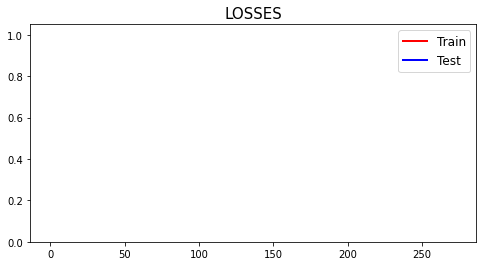

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(l_mtlr.losses['Epoch'], l_mtlr.losses['Train'], color='red', label='Train', lw=2)
plt.plot(l_mtlr.losses['Epoch'], l_mtlr.losses['Test'], color='blue', label='Test', lw=2)

# Show everything
title = "LOSSES"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t. 

In [ ]:
data_test.loc[(data_test['Churn_Yes']==1) & (data_test['tenure']>=65)].index.values

array([  86,  353,  361,  365,  386,  775,  840,  996, 1265, 1365, 1465,
       1534, 1544, 1632, 1708, 1726, 1756, 1774, 1821, 2017, 2023, 2106])

In [ ]:
k = 86
t = T_test[k]
_, _, l_predicted = l_mtlr.predict(X_test.iloc[[k]].values)
pys_predicted = lmtlr.predict_survival(X_test.iloc[[k]].values).flatten()
nmtlr_predicted = n_mtlr.predict_survival(X_test.iloc[[k]].values).flatten()

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(l_mtlr.times, l_predicted.flatten(), color='red', label='custome', lw=2)
plt.plot(lmtlr.times, pys_predicted, color='blue', label='pysurvival', lw=2)
plt.plot(n_mtlr.times, nmtlr_predicted, color='green', label='pysurvival', lw=2)

n_mtlr
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)

# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t. 

NameError: ignored

In [ ]:
l_mtlr.c_index(X_train.values, T_train, E_train), l_mtlr.c_index(X_test.values, T_test, E_test)

(0.9513072651921582, 0.9396528113873663)

In [ ]:
l = [5,6,9,8,7]
l[-1]

7

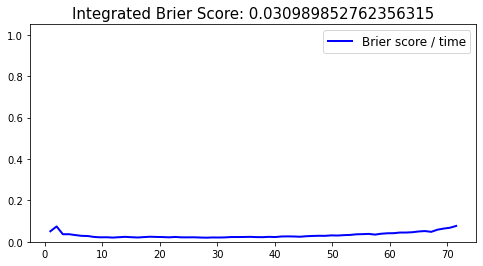

In [ ]:
brier_res, ibs, figure = l_mtlr.b_index(X_train.values, T_train, E_train, X_test.values, T_test, E_test, plot=True)
figure.show()

In [ ]:
from google.colab import files
times = pd.DataFrame(l_mtlr.times)
times.to_csv('times.csv')
files.download('times.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
data_test.to_csv('telecom_data_test.csv')
files.download('telecom_data_test.csv')

_, _, surv = l_mtlr.predict(X_test.values)
surv = pd.DataFrame(surv)
surv.to_csv('telecom_surv_pred.csv')
files.download('telecom_surv_pred.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>